In [1]:
import os
import cv2 as cv
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import seaborn as sns
from keras.utils import normalize
%matplotlib inline

# 1、数据集准备

In [2]:
image_dir_train = 'datasets/Retina Blood Vessel UNET/train/image'
mask_dir_train = 'datasets/Retina Blood Vessel UNET/train/mask'
image_dir_test = 'datasets/Retina Blood Vessel UNET/test/image'
mask_dir_test = 'datasets/Retina Blood Vessel UNET/test/mask'

images_listdir_train = os.listdir(image_dir_train)
images_listdir_mask = os.listdir(mask_dir_train)

images_dir_train: 80
images_dir_mask: 80


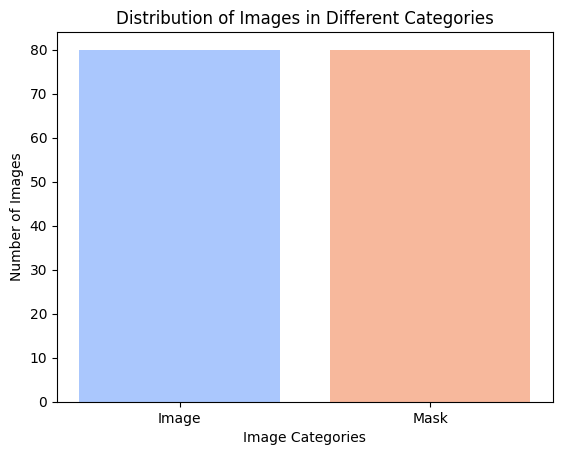

In [3]:
print("images_dir_train:",len(images_listdir_train))
print("images_dir_mask:",len(images_listdir_mask))

# Create a color gradient
colors = sns.color_palette('coolwarm', 2)

# Plotting the bar chart
plt.bar(['Image', 'Mask'], [len(images_listdir_train), 
                                  len(images_listdir_mask)], color = colors)
plt.xlabel('Image Categories')
plt.ylabel('Number of Images')
plt.title('Distribution of Images in Different Categories')
plt.show()

# 2、图像数据处理

In [4]:
# 设置原始图像 size
image_size=256
input_image_size=(256,256)
number = 200

train_image_dataset = []
train_mask_dataset = []
test_image_dataset = []
test_mask_dataset = []

# 读取图像函数
def read_images(path, gray=False):
    img = cv.imread(path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = cv.resize(img, input_image_size)
    if gray:
        img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    return img

for i, image_name in enumerate(images_listdir_train):
    if (image_name.split('.')[1] == 'png'):
        image = read_images(f"{image_dir_train}/{image_name}")
        # print('image.shape: {}'.format(image.shape))
        train_image_dataset.append(image)

for i, image_name in enumerate(images_listdir_mask):
    if (image_name.split('.')[1] == 'png'):
        image = read_images(f"{mask_dir_train}/{image_name}", gray=True)
        # print('mask.shape: {}'.format(image.shape))
        train_mask_dataset.append(image)

# 归一化 images
# train_image_dataset = np.expand_dims(normalize(np.array(train_image_dataset), axis=1),3)
train_image_dataset = normalize(np.array(train_image_dataset))
print('train_image_dataset.shape: {}'.format(train_image_dataset.shape))
# mask 不进行归一化，重定义 scale [0-1]
train_mask_dataset = np.expand_dims((np.array(train_mask_dataset)),3) /255.
# train_mask_dataset = (np.array(train_mask_dataset)) / 255.
print('train_mask_dataset.shape: {}'.format(train_mask_dataset.shape))

# 选取随机图像
random_images = np.random.choice(images_listdir_train, size = 9, replace = False)

train_image_dataset.shape: (80, 256, 256, 3)
train_mask_dataset.shape: (80, 256, 256, 1)


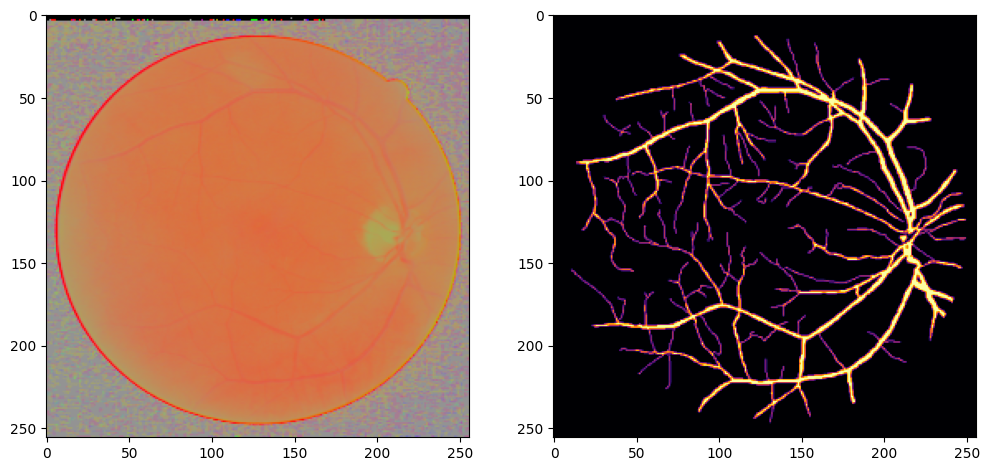

In [5]:
import random
import numpy as np
image_number = random.randint(0, len(train_image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(train_image_dataset[image_number], cmap="inferno")
plt.subplot(122)
plt.imshow(train_mask_dataset[image_number], cmap="inferno")
plt.show()

In [6]:
images_listdir_test = os.listdir(image_dir_test)
masks_listdir_test = os.listdir(mask_dir_test)
for i, image_name in enumerate(images_listdir_test):
    if (image_name.split('.')[1] == 'png'):
        image = read_images(f"{image_dir_test}/{image_name}")
        # print('image.shape: {}'.format(image.shape))
        test_image_dataset.append(image)

for i, image_name in enumerate(masks_listdir_test):
    if (image_name.split('.')[1] == 'png'):
        image = read_images(f"{mask_dir_test}/{image_name}", gray=True)
        # print('mask.shape: {}'.format(image.shape))
        test_mask_dataset.append(image)

# 归一化 images
# train_image_dataset = np.expand_dims(normalize(np.array(train_image_dataset), axis=1),3)
test_image_dataset = normalize(np.array(test_image_dataset))
print('test_image_dataset.shape: {}'.format(test_image_dataset.shape))
# mask 不进行归一化，重定义 scale [0-1]
test_mask_dataset = np.expand_dims((np.array(test_mask_dataset)),3) /255.
# train_mask_dataset = (np.array(train_mask_dataset)) / 255.
print('test_mask_dataset.shape: {}'.format(test_mask_dataset.shape))

test_image_dataset.shape: (20, 256, 256, 3)
test_mask_dataset.shape: (20, 256, 256, 1)


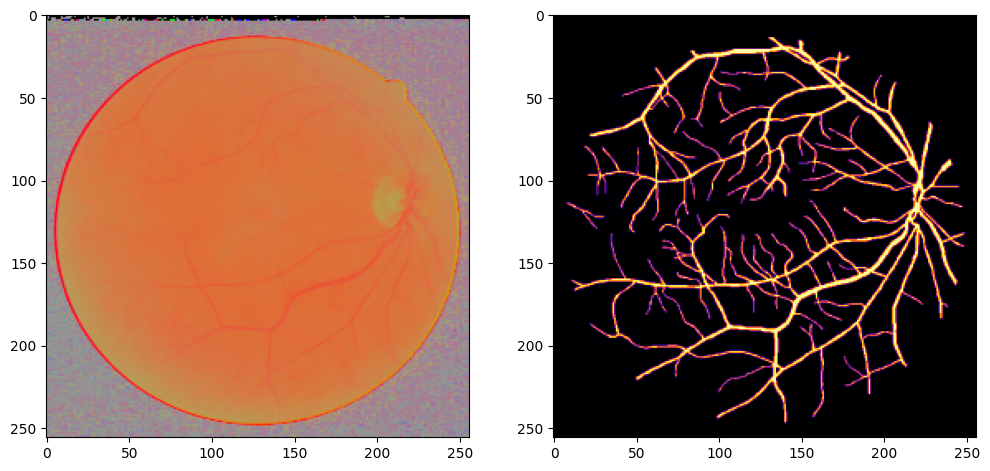

In [7]:
import random
import numpy as np
image_number = random.randint(0, len(test_image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(test_image_dataset[image_number], cmap="inferno")
plt.subplot(122)
plt.imshow(test_mask_dataset[image_number], cmap="inferno")
plt.show()

# 输入图像

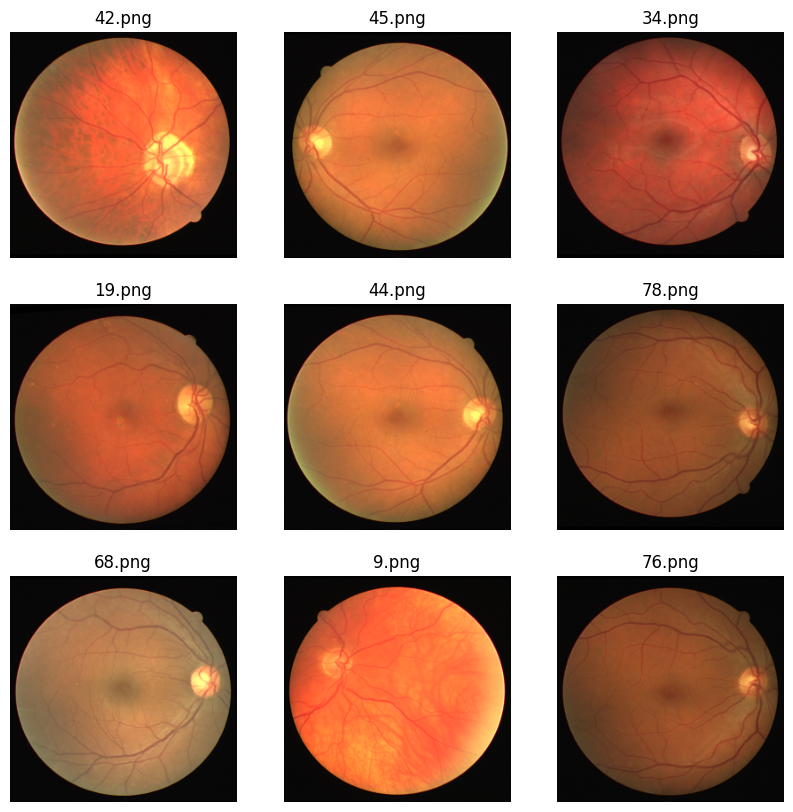

In [8]:
rows = 3
cols = 3
fig, ax = plt.subplots(rows, cols, figsize = (10,10))
# print('ax: ',ax)
for i, ax in enumerate(ax.flat):
    if i < len(random_images):
        img = read_images(f"{image_dir_train}/{random_images[i]}")
        ax.set_title(f"{random_images[i]}")
        ax.imshow(img)
        ax.axis('off')

# Ground truth masks

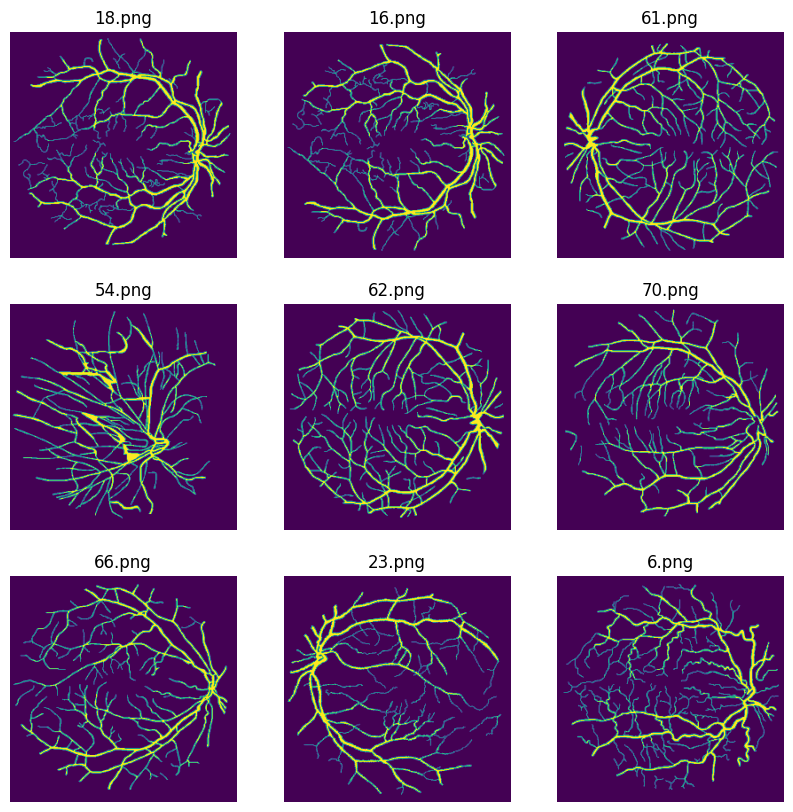

In [16]:
fig, ax = plt.subplots(rows, cols, figsize=(10, 10))
for i, ax in enumerate(ax.flat):
    file = random_images[i]
    if os.path.exists(os.path.join(mask_dir_train, file)):
        img = read_images('{}/{}'.format(mask_dir_train, file)) 
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        # print('{}: {}'.format(file, img.shape))
        ax.set_title(file)
        ax.imshow(img)
        ax.axis('off')
    else:
        print('not exit')

# 3、将 Masks和 Images的 shape保持一致

In [9]:
MASKS = np.zeros((1, image_size, image_size, 1), dtype=bool)  # 1, 256, 256, 1
IMAGES = np.zeros((1, image_size, image_size, 3), dtype=np.uint8) # 1, 256, 256, 3
for i, file in enumerate(images_listdir_train[0: number]):
    try:
        # 读取 image
        image = read_images('{}/{}'.format(image_dir_train, file))
        image_eds = np.expand_dims(image, axis=0)  # 1, 256, 256, 3  axis=0 为x
        IMAGES = np.vstack([IMAGES, image_eds])  # 256, 256, 3

        # 读取 mask
        mask = read_images('{}/{}'.format(mask_dir_train, file), gray=True) # 256, 256, 3
        mask = mask.reshape(256, 256, 1) # 256, 256, 1
        mask_eds = np.expand_dims(mask, axis=0) # 1, 256, 256, 1
        MASKS = np.vstack([MASKS, mask_eds])  # 垂直叠加  1+i, 256, 356, 1 表示处理的 mask的数量
        # print('masks.shape: ',masks.shape)
    except:
        print(file)
        continue

images = np.array(IMAGES)[1: number+1]
masks = np.array(MASKS)[1: number+1]
print('images.shape: {},  masks.shpe: {}'.format(images.shape, masks.shape))

images.shape: (80, 256, 256, 3),  masks.shpe: (80, 256, 256, 1)


# 4、构建 U-NET

In [10]:
# 定义 SENet注意力机制块
def SENet_block(input, ratio=16):
    # 获取输入的通道数
    channels = input.shape[-1]
    # 全局平均池化
    se = tf.keras.layers.GlobalAveragePooling2D()(input)
    # 压缩通道
    se = tf.keras.layers.Dense(channels // ratio, activation='relu')(se)
    # 恢复形状
    se = tf.keras.layers.Dense(channels, activation='sigmoid')(se)
    se = tf.keras.layers.Reshape((1, 1, channels))(se)
    # 通道加权
    x = tf.keras.layers.Multiply()([input, se])
    return x

def conv_blcok(input, num_filters):
    conv1 = tf.keras.layers.Conv2D(num_filters, 3, padding='same')(input)
    bn1 = tf.keras.layers.BatchNormalization()(conv1)
    act1 = tf.keras.layers.Activation('silu')(bn1)
    conv2 = tf.keras.layers.Conv2D(num_filters, 3, padding='same')(act1)
    bn2 = tf.keras.layers.BatchNormalization()(conv2)
    act2 = tf.keras.layers.Activation('silu')(bn2)
    
    # 添加 SENet 自注意力机制
    se = SENet_block(act2)
    # 将注意力机制应用到激活后的特征图
    x = tf.keras.layers.Multiply()([act2, se])
    return x

def encoder_block(input, num_filters):
    skip = conv_blcok(input, num_filters)
    pool = tf.keras.layers.MaxPool2D((2,2))(skip)
    return skip, pool

def decoder_block(input, skip, num_filters):
    up_conv = tf.keras.layers.Conv2DTranspose(num_filters, (2,2),
                        strides=2, padding='same')(input)
    conv = tf.keras.layers.Concatenate()([up_conv, skip])
    conv = conv_blcok(conv, num_filters)
    return conv

def Unet(input_shape):
    inputs = tf.keras.layers.Input(input_shape)

    skip1, pool1 = encoder_block(inputs, 64)
    skip2, pool2 = encoder_block(pool1, 128)
    skip3, pool3 = encoder_block(pool2, 256)
    skip4, pool4 = encoder_block(pool3, 512)
    
    bridge= conv_blcok(pool4, 1024)

    decode1 = decoder_block(bridge, skip4, 512)
    decode2 = decoder_block(decode1, skip3, 256)
    decode3 = decoder_block(decode2, skip2, 128)
    decode4 = decoder_block(decode3, skip1, 64)
    outputs = tf.keras.layers.Conv2D(1, 1, padding='same', activation='sigmoid')(decode4)
    model = tf.keras.models.Model(inputs, outputs, name='U-net')
    return model
inputs = train_image_dataset.shape[1], train_image_dataset.shape[2], train_image_dataset.shape[3]
unet_model = Unet(inputs)
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# unet_model.summary()

# 5、模型训练

In [11]:
unet_result = unet_model.fit(train_image_dataset, train_mask_dataset, batch_size=2, 
        validation_data=(test_image_dataset, test_mask_dataset), epochs=200, verbose=1, shuffle=False)

Epoch 1/200
40/40 [==============================] - 25s 317ms/step - loss: 0.5544 - accuracy: 0.7816 - val_loss: 0.6662 - val_accuracy: 0.8388
Epoch 2/200
40/40 [==============================] - 12s 298ms/step - loss: 0.4139 - accuracy: 0.8390 - val_loss: 0.6292 - val_accuracy: 0.8388
Epoch 3/200
40/40 [==============================] - 12s 299ms/step - loss: 0.3309 - accuracy: 0.8390 - val_loss: 0.6082 - val_accuracy: 0.8388
Epoch 4/200
40/40 [==============================] - 12s 299ms/step - loss: 0.2494 - accuracy: 0.8391 - val_loss: 0.5237 - val_accuracy: 0.8388
Epoch 5/200
40/40 [==============================] - 12s 300ms/step - loss: 0.2063 - accuracy: 0.8415 - val_loss: 0.4639 - val_accuracy: 0.8388
Epoch 6/200
40/40 [==============================] - 12s 300ms/step - loss: 0.1810 - accuracy: 0.8538 - val_loss: 0.4171 - val_accuracy: 0.8388
Epoch 7/200
40/40 [==============================] - 12s 300ms/step - loss: 0.1712 - accuracy: 0.8561 - val_loss: 0.4114 - val_accuracy:

# 6、模型预测和检验

1/1 [==============================] - 2s 2s/step


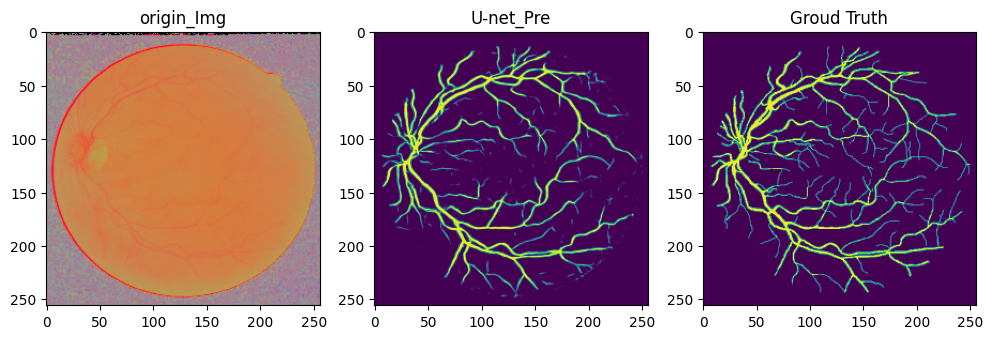

1/1 [==============================] - 0s 27ms/step


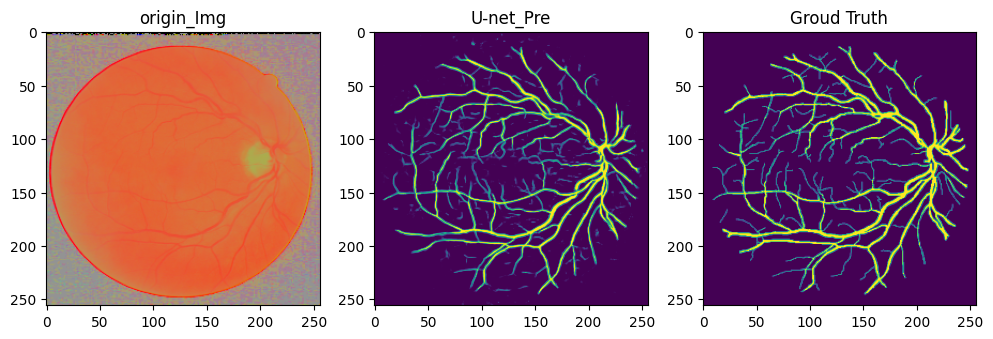

1/1 [==============================] - 0s 29ms/step


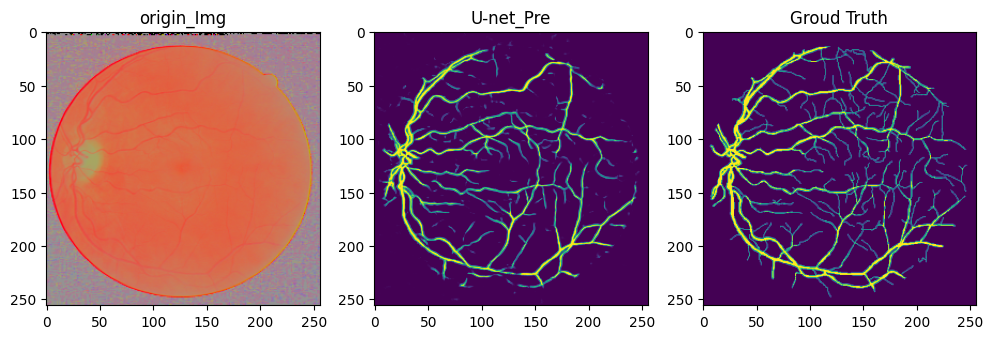

1/1 [==============================] - 0s 27ms/step


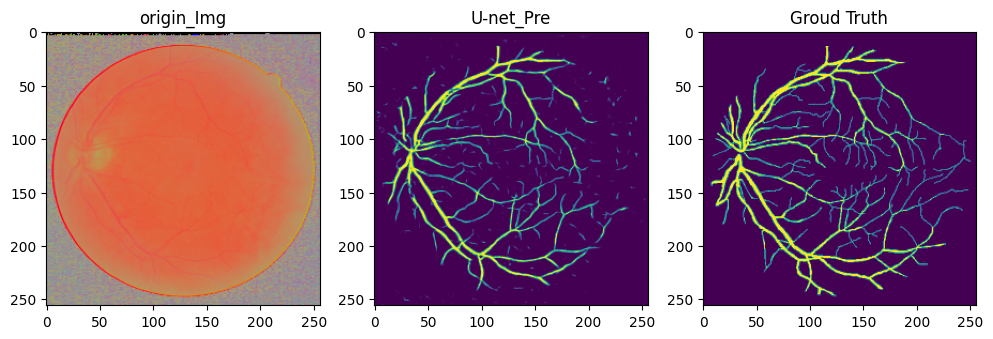

1/1 [==============================] - 0s 28ms/step


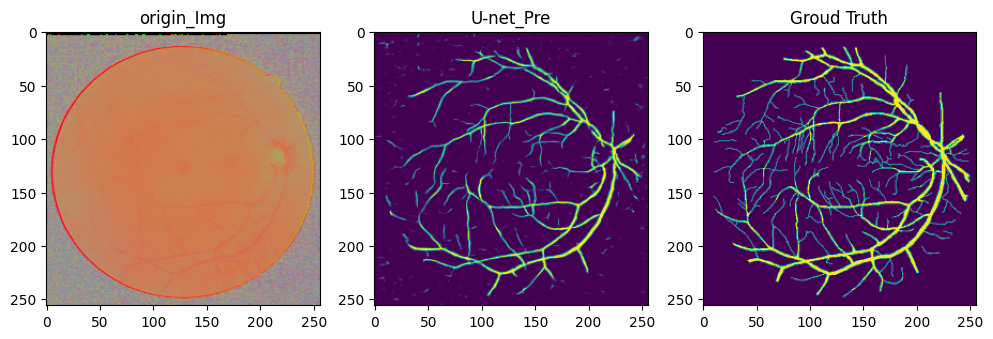

1/1 [==============================] - 0s 27ms/step


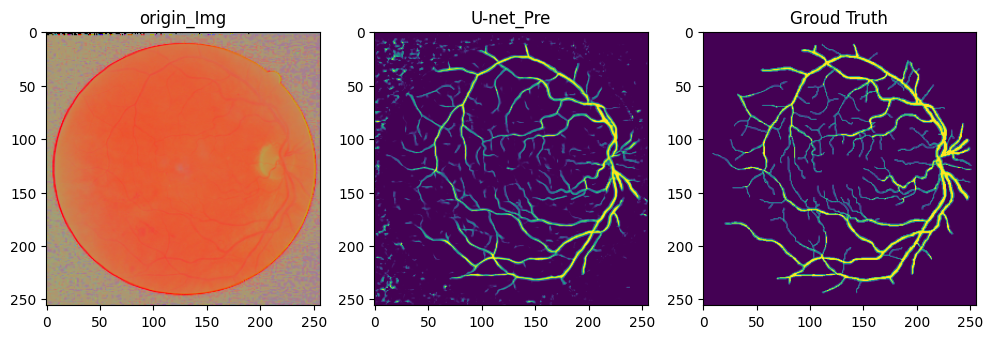

1/1 [==============================] - 0s 27ms/step


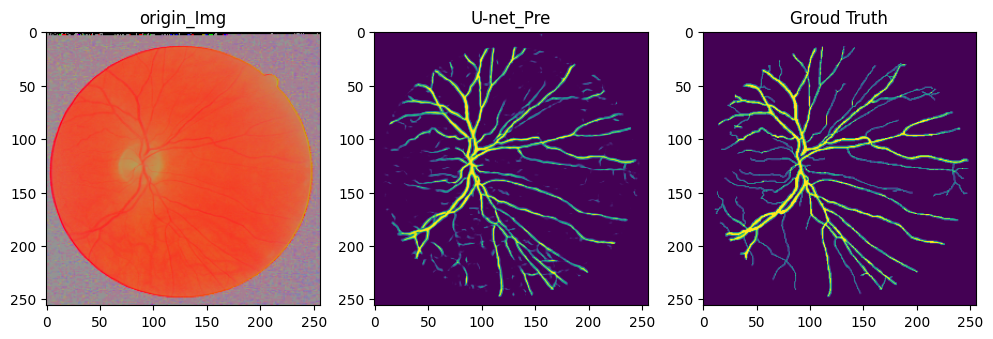

1/1 [==============================] - 0s 30ms/step


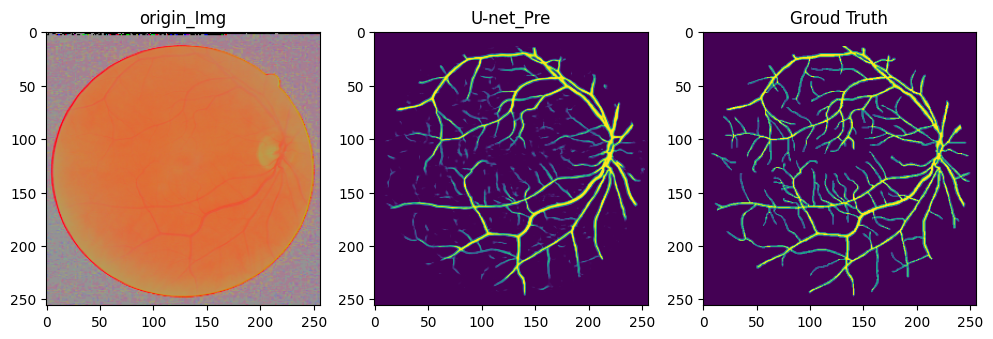

1/1 [==============================] - 0s 33ms/step


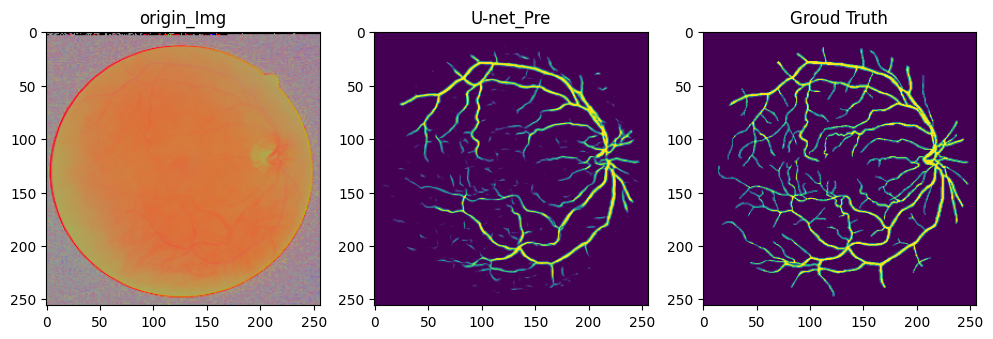

1/1 [==============================] - 0s 27ms/step


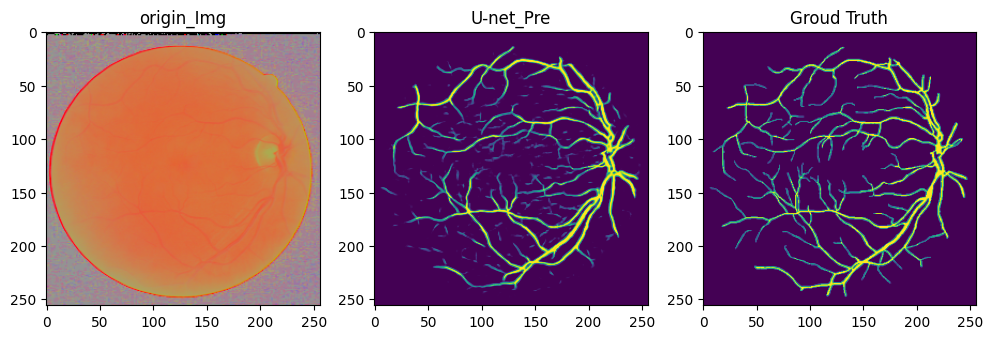

1/1 [==============================] - 0s 28ms/step


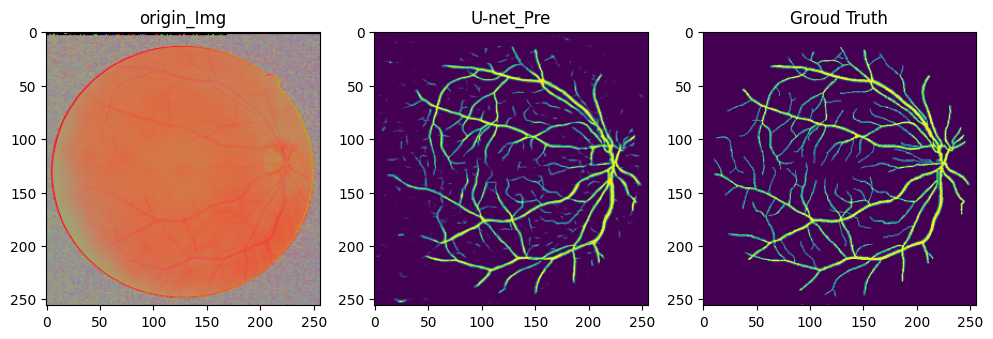

1/1 [==============================] - 0s 28ms/step


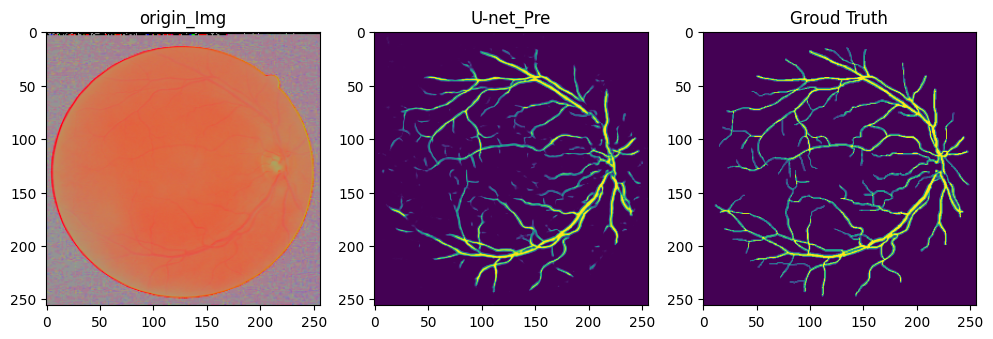

1/1 [==============================] - 0s 30ms/step


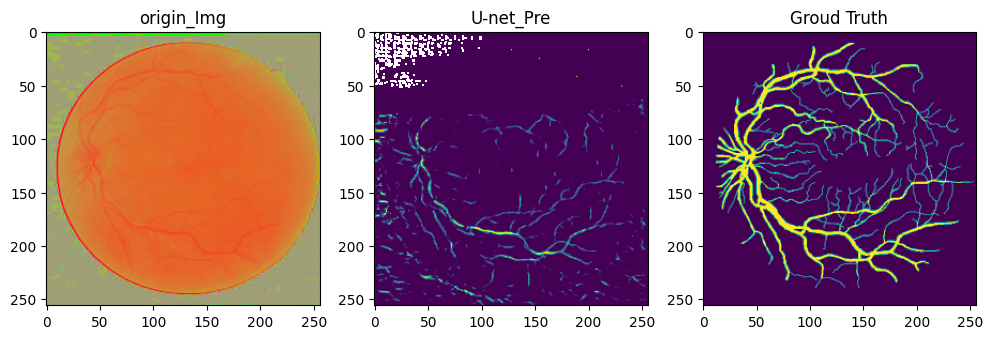

1/1 [==============================] - 0s 32ms/step


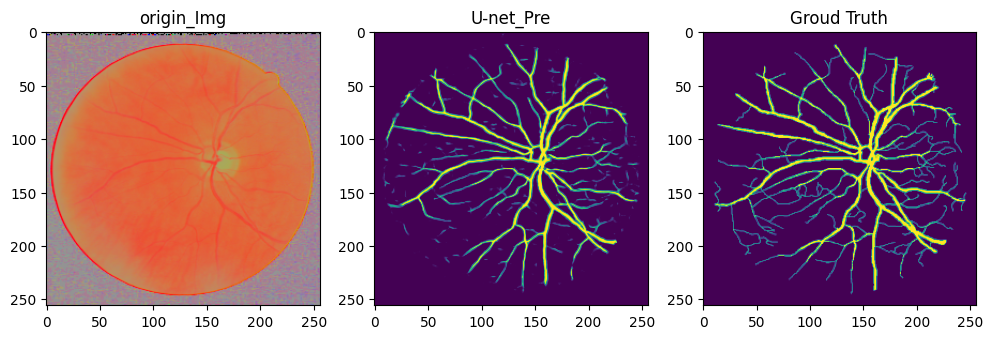

1/1 [==============================] - 0s 27ms/step


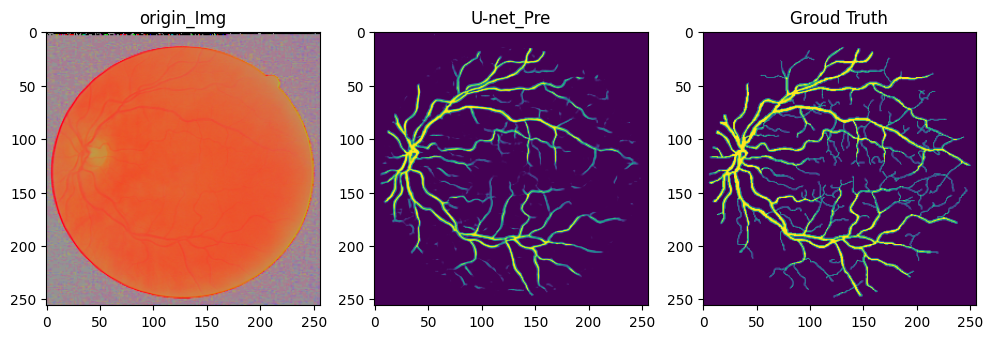

1/1 [==============================] - 0s 29ms/step


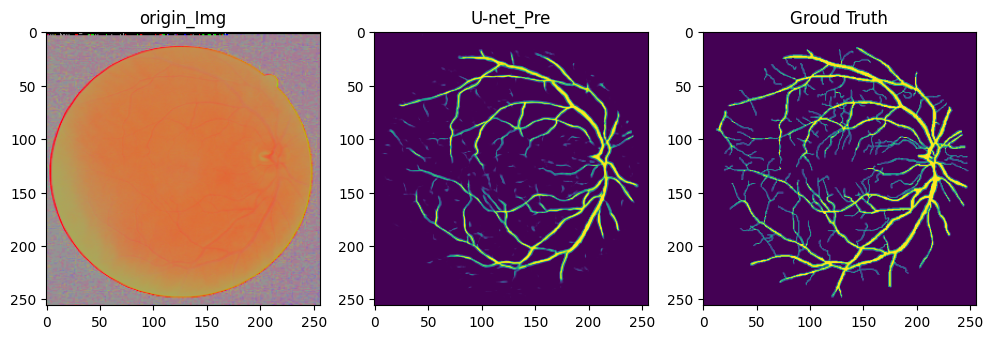

1/1 [==============================] - 0s 29ms/step


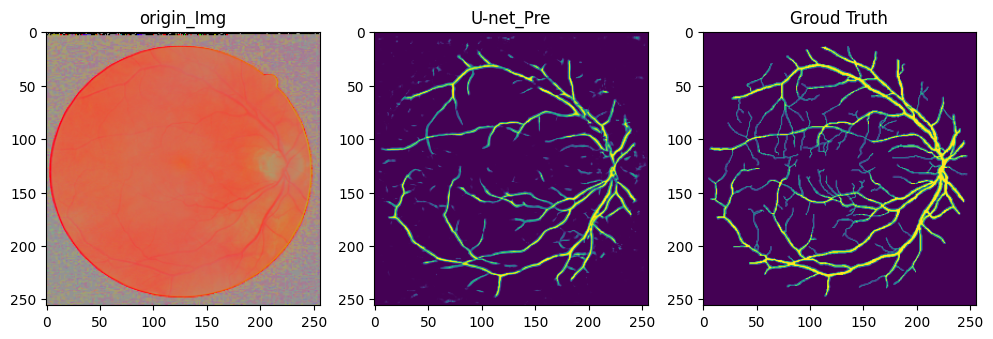

1/1 [==============================] - 0s 27ms/step


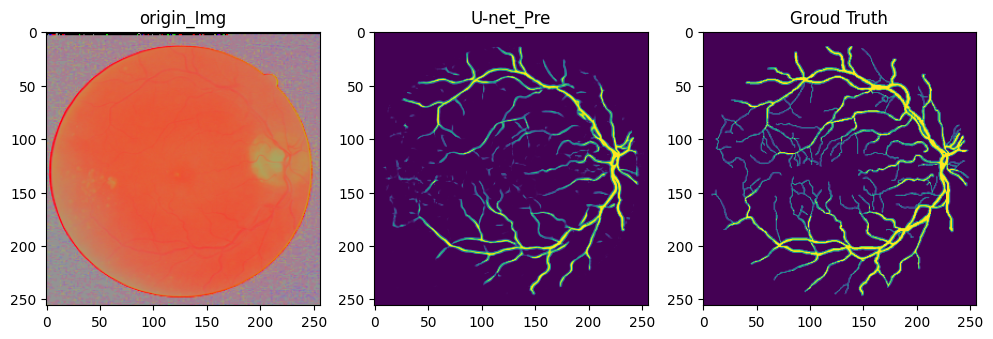

1/1 [==============================] - 0s 31ms/step


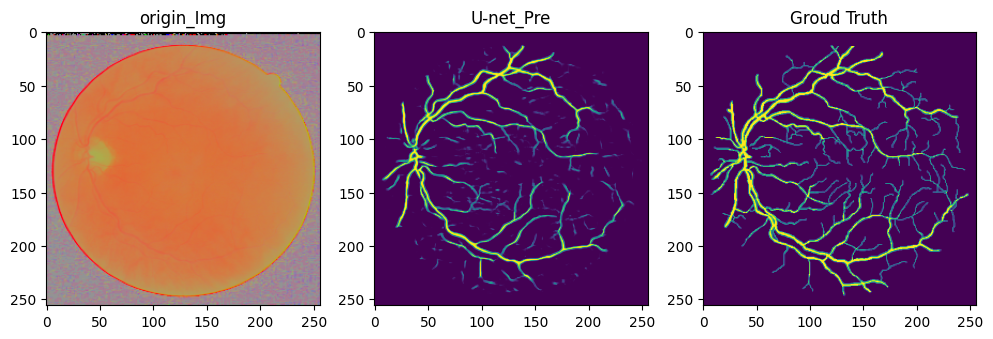

In [12]:
for id in range(19):
    # U-net预测
    unet_predict= unet_model.predict(np.expand_dims(test_image_dataset[id], axis=0))
    # 显示原始图像和预测结果
    plt.figure(figsize=(12, 12))
    # 显示原始图像
    plt.subplot(1, 3, 1)
    plt.title('origin_Img')
    plt.imshow(test_image_dataset[id]) 
    # 显示预测结果
    plt.subplot(1, 3, 2)
    plt.title('U-net_Pre')
    plt.imshow(unet_predict[0])  
    # 显示 Groud Truth
    plt.subplot(1, 3, 3)
    plt.title('Groud Truth')
    plt.imshow(test_mask_dataset[id])  
    # 显示图像
    plt.show()

# 9、train 模型可视化

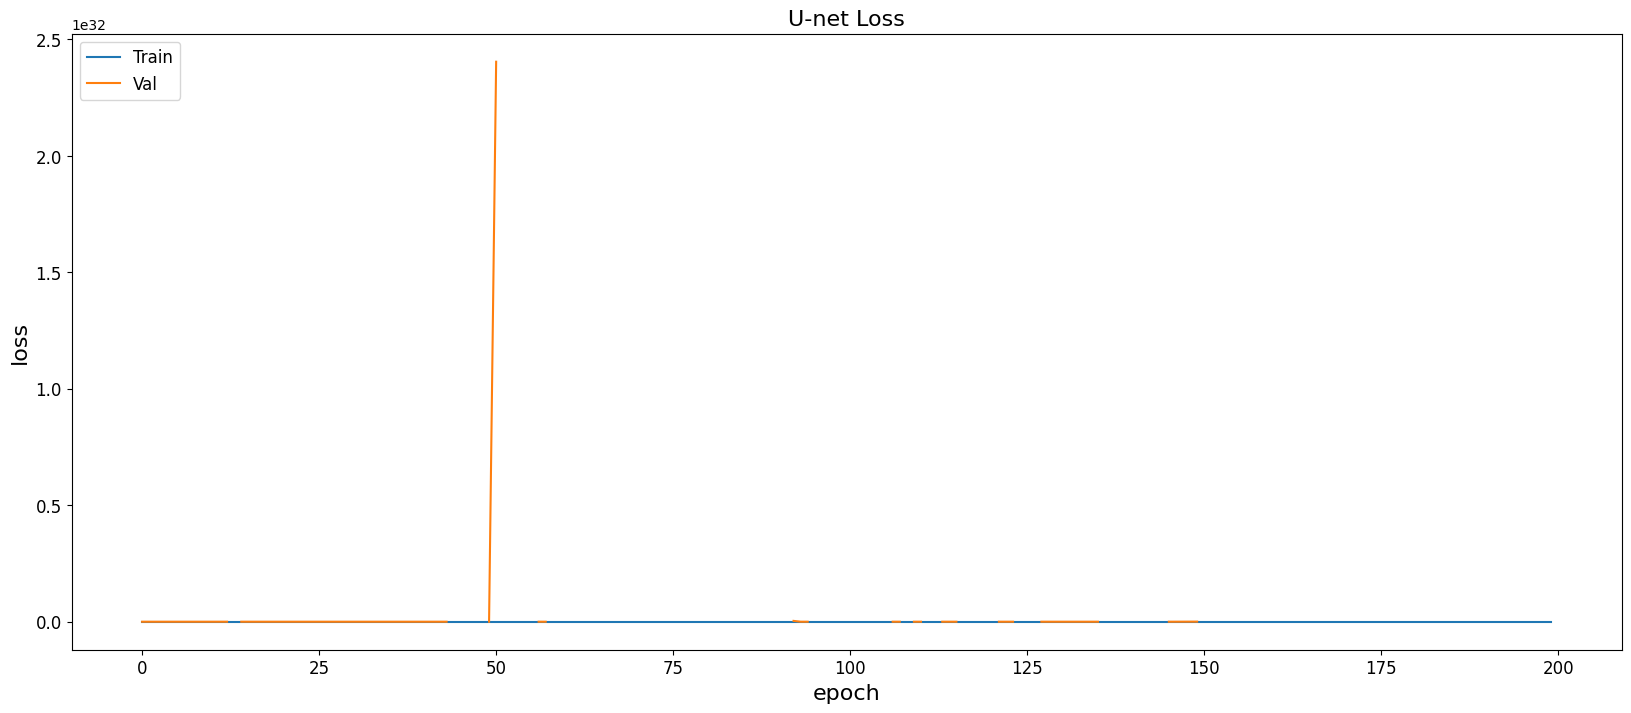

In [13]:
plt.figure(figsize=(20,8))
plt.plot(unet_result.history['loss'])
plt.plot(unet_result.history['val_loss'])
plt.title('U-net Loss', fontsize=16)
plt.ylabel('loss', fontsize=16)
plt.xlabel('epoch', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(['Train', 'Val'], loc='upper left', fontsize=12)
plt.show()

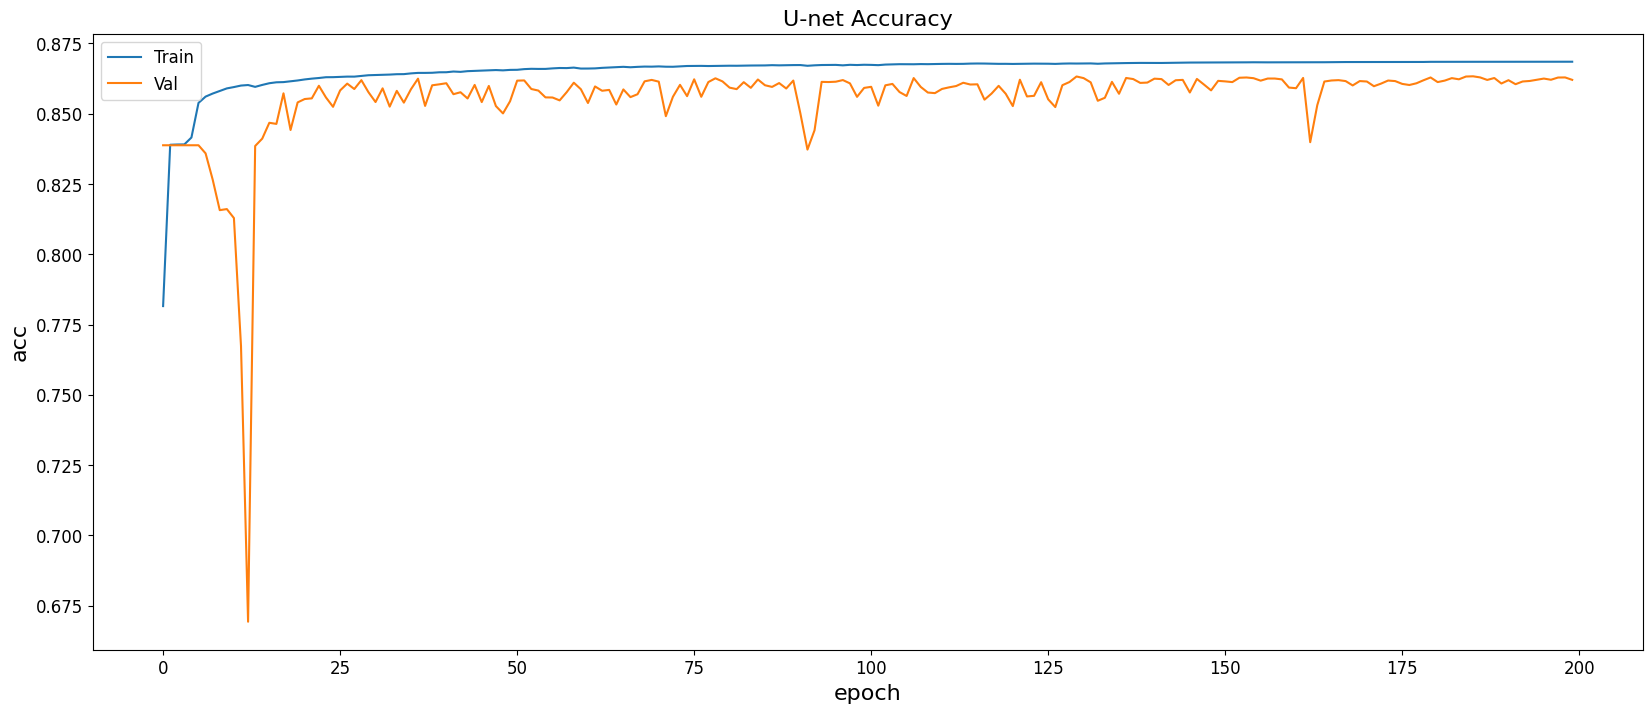

In [14]:
plt.figure(figsize=(20,8))
plt.plot(unet_result.history['accuracy'])
plt.plot(unet_result.history['val_accuracy'])
plt.title('U-net Accuracy', fontsize=16)
plt.ylabel('acc', fontsize=16)
plt.xlabel('epoch', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(['Train', 'Val'], loc='upper left', fontsize=12)
plt.show()